In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation-models-3D
# !pip install tensorflow==2.8
!pip install split-folders
!pip install keras_tuner

In [ ]:
import numpy as np
from keras.models import load_model
import pandas as pd
import json
import nibabel as nib
import segmentation_models_3D as sm
import splitfolders
import glob
import random
import os
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler

Segmentation Models: using `tf.keras` framework.


# Data Preprocessing

In [ ]:
# check if all the needed files are present in the directories
import os
def count_images(root_folder: str = '/content/drive/MyDrive/stroke/data/train') -> tuple():
  count = 0
  folders = []
  for folder_name in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, folder_name)
    if os.path.isdir(folder_path):
      files = os.listdir(folder_path)
      if any(["_ses-1_T1w.nii.gz" in file for file in files]):
        folders.append(folder_path)
        count += 1
  return folders, count

folders, counts = count_images()
print("Number of train images:", counts)

Number of train images: 511


In [ ]:
def count_test(test_dir:str = "/content/drive/MyDrive/stroke/data/test") -> int:
  return len(os.listdir(test_dir))

print("Number of test images:", count_test())

Number of test images: 300


Not all files present had both MRI images and mask files, so this function checks through our train data, and creates a list of all folders with both `images` and `masks`

In [ ]:
# check if all the needed files are present in the directories
def get_folders_with_both_files(root_folder: str) -> list[str]:
  folders = []
  for folder_name in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, folder_name)
    if os.path.isdir(folder_path):
      files = os.listdir(folder_path)
      if len(files) == 2:
        folders.append(folder_path)
  return folders

root_folder = '/content/drive/MyDrive/stroke/data/train'
train_folders = get_folders_with_both_files(root_folder)
print("Number of folders with both image and annotation files:", len(train_folders))

Number of folders with both image and annotation files: 510


###Viewing a Random Image
Most of the MRI images have a wide range of values, (as seen below), and this may reduce the performance of the model, so we scaled all values, and brought them all to a similar range with the `MinMaxScaler` from sklearn

In [ ]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/stroke/data/train'

# defining the scaler
scaler = MinMaxScaler()

test_image = nib.load("/content/drive/MyDrive/stroke/data/train/sub-r047s044/sub-r047s044_ses-1_T1w.nii.gz").get_fdata()
print("Max before scaling:", test_image.max())
print("Size:", test_image.shape, end="\n")

# scaling image data
test_image=scaler.fit_transform(test_image.reshape(-1, test_image.shape[-1])).reshape(test_image.shape)
print("Max after scaling:", test_image.max())
print("Size:", test_image.shape)

Max before scaling: 1932.0
Size: (176, 248, 256)
Max after scaling: 1.0
Size: (176, 248, 256)


Some masks may have values in floats, so for the sake of uniformity, we converted them to numpy's `unit8` so they can only assume values *0* and *1*

In [ ]:
# converting mask to uint
test_mask=nib.load(os.path.join("/content/drive/MyDrive/stroke/data/train/sub-r047s044/sub-r047s044_ses-1_space-orig_label-L_desc-T1lesion_mask.nii.gz")).get_fdata()
print("Floats:", np.unique(test_mask))

test_mask=test_mask.astype(np.uint8)

print("Uint8:", np.unique(test_mask))
print(test_mask.shape)

Floats: [0. 1.]
Uint8: [0 1]
(176, 248, 256)


### Visualizing scaled image

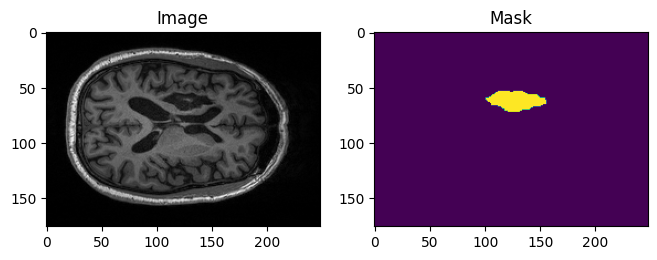

In [ ]:
# plotting a slice near the mid of the image
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image[:,:,145], cmap='gray')
plt.title('Image')
plt.subplot(232)
plt.imshow(test_mask[:,:,145])
plt.title('Mask')
plt.show()

### Getting rid of empty areas
A slice of an MRI image typically has a lot of black pixels surrounding it. A technique usually used to combat this is to `crop` a uniform shape (say 128x128x128) out of the image, but in our case, cropping is detrimental as it can remove important data. So `resizing` was the route we took.

In [ ]:
def resize_data(data):
  """Function to resize images and masks to 128x128x128"""

  # Define the target size for resizing
  target_size = (128, 128, 128)

  # Calculate the resize factors for each dimension
  resize_factors = [target_size[i] / data.shape[i] for i in range(3)]

  # Perform the resize using bilinear interpolation
  resized_data = zoom(data, resize_factors, order=1)
  return resized_data

resized_img = resize_data(test_image)
resized_mask = resize_data(test_mask)

resized_img = np.expand_dims(resized_img, axis=-1)
resized_mask = np.expand_dims(resized_mask, axis=-1)

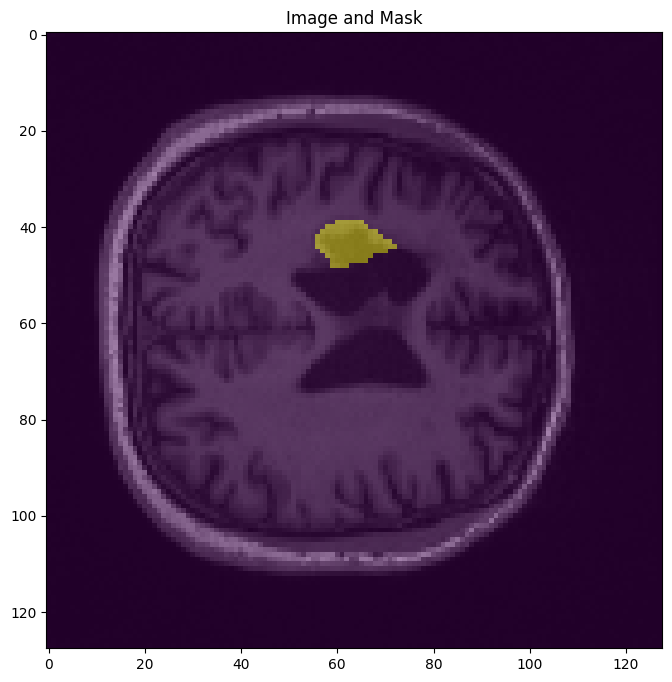

In [ ]:
# plotting the resized image
plt.figure(figsize=(12, 8))

plt.imshow(resized_img[:,:,80], cmap='gray')
plt.imshow(resized_mask[:,:,80], alpha=0.5)
plt.title('Image and Mask')
plt.show()

# Preprocessing the Entire Set
These preprocessing steps were carried out:

1.) Scaling all images to a range of 0-1

2.) Resizing all images to a size of 128x128x128X1

3.) Converting all masks to `uint8` types and then back to `float32`

4.) Retaining only masks with at least `0.5%` of useful masks for training

5.) Saving images and masks as `.npy` files.

6.) Splitting the images and masks into `75%` and `25%` for training and validation sets.

In [ ]:
# sorting images and masks
img_list = sorted([os.path.join(folder, folder.split("/")[-1] + "_ses-1_T1w.nii.gz") for folder in train_folders])
mask_list = sorted([os.path.join(folder, folder.split("/")[-1] + "_ses-1_space-orig_label-L_desc-T1lesion_mask.nii.gz") for folder in train_folders])

In [ ]:
# creating directories to work with
!mkdir /content/drive/MyDrive/stroke/data/preprocessed
!mkdir /content/drive/MyDrive/stroke/data/preprocessed/images
!mkdir /content/drive/MyDrive/stroke/data/preprocessed/masks

In [ ]:
# checking for relevant pixels and saving files
count = 0
for img in range(len(img_list)):

  temp_image = nib.load(img_list[img]).get_fdata()
  temp_image = scaler.fit_transform(temp_image.reshape(-1, temp_image.shape[-1])).reshape(temp_image.shape)
  temp_image = resize_data(temp_image)
  temp_image = np.expand_dims(temp_image, axis=-1)

  temp_mask = nib.load(mask_list[img]).get_fdata()
  temp_mask = temp_mask.astype(np.uint8)
  temp_mask = resize_data(temp_mask)

  val, counts = np.unique(temp_mask, return_counts=True)

  if (1 - (counts[0]/counts.sum())) > 0.005:  #At least 0.5% useful volume with labels that are not 0
    temp_mask = temp_mask.astype(np.float32)
    temp_mask = np.expand_dims(temp_mask, axis=-1)
    print(temp_mask.shape)
    print(np.unique(temp_mask))

    np.save('/content/drive/MyDrive/stroke/data/preprocessed/images/image_'+str(img)+'.npy', temp_image)
    np.save('/content/drive/MyDrive/stroke/data/preprocessed/masks/mask_'+str(img)+'.npy', temp_mask)
    count += 1

print("Number of imgs/masks saved:", count)

In [ ]:
# creating a new directory

input_folder = '/content/drive/MyDrive/stroke/data/preprocessed'
output_folder = '/content/drive/MyDrive/stroke/data/split'

# splitting into the tradtional keras .flow_from_directory directory structure
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)

Copying files: 136 files [00:18,  7.54 files/s]


# Defining a Custom Generator
As we are working with `.npy` files, the keras datagenerators cannot work with them. So we create a custom datagenerator that has the basic functionality of yielding `images` and `masks`

In [ ]:
# custom datagenerator
def load_img(img_dir: str, img_list: list[str]):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):
            image = np.load(img_dir+image_name)
            images.append(image)
    images = np.array(images)

    return(images)

def imageLoader(img_dir: str, img_list: list[str], mask_dir: str, mask_list: list[str], batch_size: int):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

In [ ]:
# testing the generator

train_img_dir = "/content/drive/MyDrive/stroke/data/split/train/images/"
train_mask_dir = "/content/drive/MyDrive/stroke/data/split/train/masks/"

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 4

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

img, msk = train_img_datagen.__next__()

In [ ]:
img.shape, msk.shape

((4, 128, 128, 128, 1), (4, 128, 128, 128, 1))

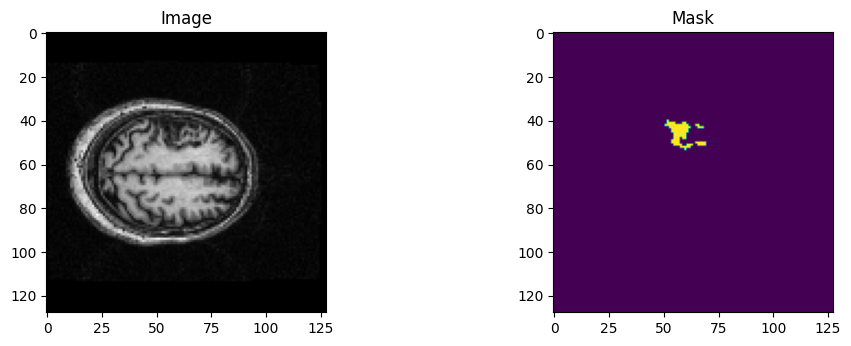

In [ ]:
# visualising a slice of the yielded images
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(img[0,:,:,98], cmap='gray')
plt.title('Image')
plt.subplot(222)
plt.imshow(msk[0,:,:,98])
plt.title('Mask')
plt.show()

# Training Model

The first model we are training, is a simple `3D-UNET` model which is like the `2D-unet` model, but is adjusted for `3D` inputs (like MRI images).

In [ ]:
# define simple 3D unet model
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU, OneHotIoU, BinaryIoU
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

### Determining weights for each class
It is common practice to assign weights to classes when working with an unbalanced dataset. And in our case, our dataset is indeed imbalanced, with a majority of samples having very few masks. So we use the `class weights` formular to determine optimal weights for each class.

In [ ]:
# creating a dataframe of all masks and looping through their pixel counts to calculate good weights
columns = ['0','1']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('/content/drive/MyDrive/stroke/data/split/train/masks/*.npy'))

for img in range(len(train_mask_list)):
    temp_image = np.load(train_mask_list[img])
    # temp_image = np.argmax(temp_image, axis=-1)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)

    df = pd.concat([df, pd.DataFrame(conts_dict, index=[0])], ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()

total_labels = label_0 + label_1
n_classes = 2

#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)

print("W1:", wt0)
print("W2:", wt1)

W1: 0.51
W2: 46.35


### Defining Directories

In [ ]:
train_img_dir = "/content/drive/MyDrive/stroke/data/split/train/images/"
train_mask_dir = "/content/drive/MyDrive/stroke/data/split/train/masks/"

val_img_dir = "/content/drive/MyDrive/stroke/data/split/val/images/"
val_mask_dir = "/content/drive/MyDrive/stroke/data/split/val/masks/"

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

### Creating datagenerators for `train` and `val`

In [ ]:
batch_size = 4

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

### Calculating steps_per_epoch

In [ ]:
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

In [ ]:
steps_per_epoch, val_steps_per_epoch

(12, 4)

# Optimizers, Metrics and Loss functions
We made use of the standard loss function for binary segmentation problems, the `DiceLoss`. Our metrics of choice here are the `DiceCoefficient` + `IOU score` and for our choice of optimizer, we went with the good ol' `Adam`

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1):
  y_true = K.flatten(y_true)
  y_pred = K.flatten(y_pred)
  intersection = K.sum(y_true * y_pred)
  dice = (2.0 * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
  return dice

def my_dice_loss(y_true, y_pred):
  return 1-dice_coefficient(y_true, y_pred)

metrics = [dice_coefficient, sm.metrics.IOUScore(threshold=0.5)]

LR = 1e-4
optim = Adam(LR)

callbacks = [ModelCheckpoint("unet.h5", verbose=1, save_best_only=True)]

# Compiling and Training
We made use of a `ModelCheckpoint` callback to monitor the `val_loss` and save the best model after every epoch. The model was trained for a `100` epochs on Google Colab's `T4` GPU with a *batch_size* of **4**

In [ ]:
model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=1,
                          num_classes=1)

model.compile(optimizer = optim, loss = my_dice_loss, metrics=metrics)

print(model.input_shape)
print(model.output_shape)

history = model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=callbacks
          )

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.9770 - dice_coefficient: 0.0229 - iou_score: 0.0105
Epoch 1: val_loss improved from inf to 0.97407, saving model to unet.h5
12/12 [==============================] - 30s 2s/step - loss: 0.9770 - dice_coefficient: 0.0229 - iou_score: 0.0105 - val_loss: 0.9741 - val_dice_coefficient: 0.0239 - val_iou_score: 0.0103
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.9740 - dice_coefficient: 0.0259 - iou_score: 0.0110
Epoch 2: val_loss improved from 0.97407 to 0.97366, saving model to unet.h5
12/12 [==============================] - 26s 2s/step - loss: 0.9740 - dice_coefficient: 0.0259 - iou_score: 0.0110 - val_loss: 0.9737 - val_dice_coefficient: 0.0243 - val_iou_score: 0.0106
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.9727 - dice_coefficient: 0.0272 - iou_score: 0.0112
Epoch 3: val_loss improved from 0.97366 to 0.96979, saving model to unet.h5
12/12 [======================

### Saving history object
After training, the history object is saved due to the nature of Colab's runtime disconnecting.

In [ ]:
with open("/content/drive/MyDrive/stroke/data/second-unet-logs.json", "w") as f:
  json.dump(history.history, f)

In [ ]:
with open("/content/drive/MyDrive/stroke/data/second-unet-logs.json", "r") as data:
  data = json.load(data)

# Model Scores

In [ ]:
print(f"Best validation dice coefficient: {max(data['val_dice_coefficient']) :.4f}")
print(f"Best training loss coefficient: {min(data['loss']) :.4f}")

Best training dice coefficient: 0.8363
Best validation dice coefficient: 0.5970
Best validation loss coefficient: 0.4153


# Visualizing the model
After training, we visualized the model's

*   Loss
*   Dice Coefficient
*   IOU score

In [ ]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

train_dice = history.history["dice_coefficient"]
val_dice = history.history["val_dice_coefficient"]

train_iou = history.history["iou_score"]
val_iou = history.history["val_iou_score"]

# Loss

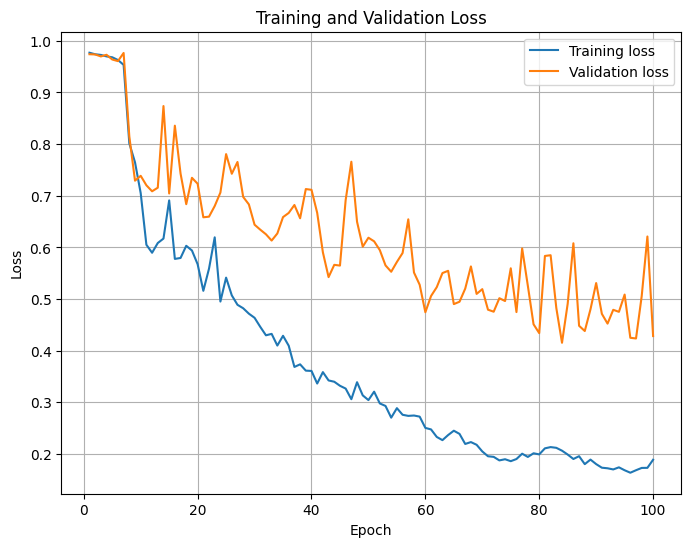

In [ ]:
# Plotting the loss values
plt.figure(figsize=(8, 6))
plt.plot(range(1, 101), train_loss, label='Training loss')
plt.plot(range(1, 101), val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/stroke/data/second-unet-loss.png")

# Dice Coefficient

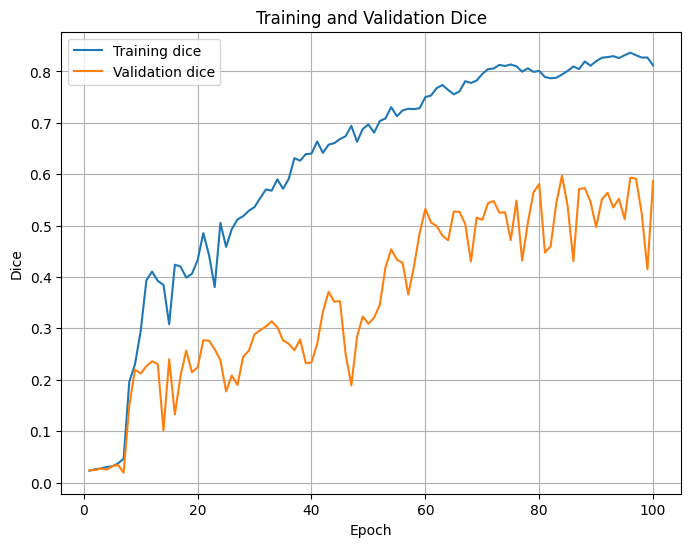

In [ ]:
# Plotting the dice coef values
plt.figure(figsize=(8, 6))
plt.plot(range(1, 101), train_dice, label='Training dice')
plt.plot(range(1, 101), val_dice, label='Validation dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Training and Validation Dice')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/stroke/data/second-unet-dice.png")

# IOU score

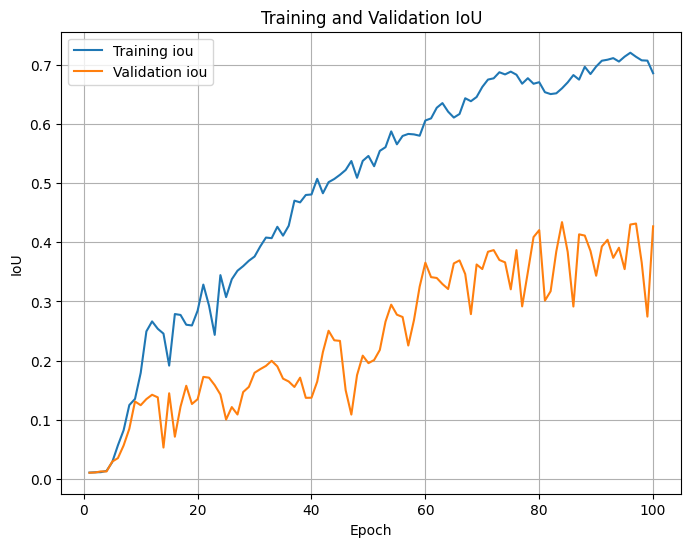

In [ ]:
# Plotting the iou values
plt.figure(figsize=(8, 6))
plt.plot(range(1, 101), train_iou, label='Training iou')
plt.plot(range(1, 101), val_iou, label='Validation iou')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/stroke/data/second-unet-iou.png")

# Loading the Model and making Predictions

In [ ]:
model = load_model("/content/drive/MyDrive/stroke/data/second-unet.h5", compile=False)

In [ ]:
test_img = "/content/drive/MyDrive/stroke/data/split/val/images/image_367.npy"
test_mask = "/content/drive/MyDrive/stroke/data/split/val/masks/mask_367.npy"

print(test_img, test_mask)

test_img = np.load(test_img)
test_mask = np.load(test_mask)

test_img_input = np.expand_dims(test_img, axis=0)

/content/drive/MyDrive/stroke/data/split/val/images/image_367.npy /content/drive/MyDrive/stroke/data/split/val/masks/mask_367.npy


In [ ]:
np.unique(test_mask)

array([0., 1.], dtype=float32)

In [ ]:
test_prediction = model.predict(test_img_input)
pred = np.squeeze(test_prediction, axis=0) > 0.5

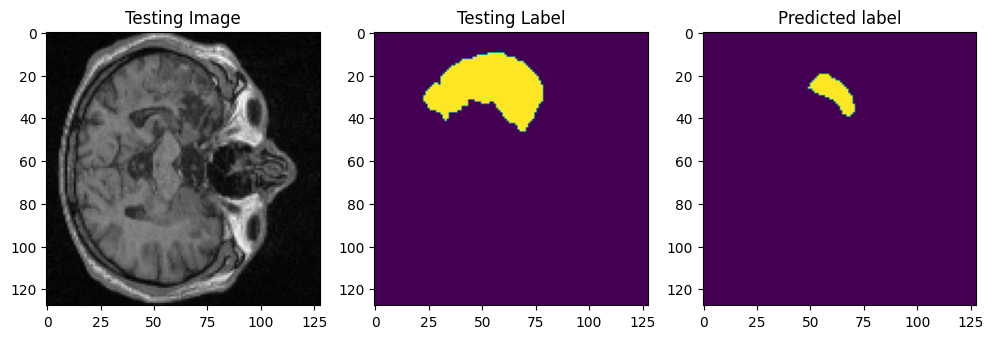

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,71], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask[:,:,71])
plt.subplot(233)
plt.title('Predicted label')
plt.imshow(pred[:,:, 71])
plt.savefig("Prediction_on_slice_71.png")

In [ ]:
n_slice = random.randint(0, pred.shape[0]-1)
n_slice

90

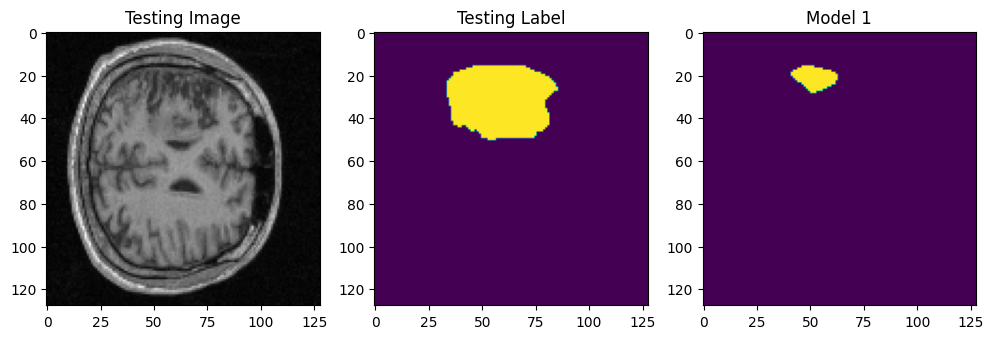

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask[:,:,n_slice])
plt.subplot(233)
plt.title('Predicted label')
plt.imshow(pred[:,:, n_slice])
plt.show()

# Hyperameter Tuning
We make use of the KerasTuner object to find the optimal values for *learning rate* and the *smooth* parameter used for the `dice coefficient` and `dice loss`

In [ ]:
from keras_tuner import RandomSearch, Objective

def dice_coefficient(y_true, y_pred, smooth=1):
  y_true = K.flatten(y_true)
  y_pred = K.flatten(y_pred)
  intersection = K.sum(y_true * y_pred)
  dice = (2.0 * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
  return dice

def my_dice_loss(y_true, y_pred):
  return 1-dice_coefficient(y_true, y_pred)

metrics = [dice_coefficient, sm.metrics.IOUScore(threshold=0.5)]

def build_model(hp):
    # Define the hyperparameters to be tuned
    lr = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 3e-4])

    # Compile the model with the specified optimizer and learning rate
    model = simple_unet_model(128, 128, 128, 1, 1)

    model.compile(optimizer=Adam(learning_rate=lr), loss=my_dice_loss, metrics=metrics)
    return model

def hyperparameter_tuning():
    # Create a tuner instance with the build_model function and other settings
    tuner = RandomSearch(
        build_model,
        objective=Objective('val_dice_coefficient', direction = 'max'),
        max_trials=10,
        executions_per_trial=1,
        directory='hyperparameter_tuning',
        project_name='unet_tuning')

    # Start the hyperparameter search
    tuner.search(train_img_datagen, steps_per_epoch=steps_per_epoch, epochs=15, validation_data=val_img_datagen, validation_steps=val_steps_per_epoch)

    # Get the best hyperparameters and the best model
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]

    # Print the best hyperparameters
    print("Best Hyperparameters:")
    print(best_hp.values)

    return best_model

model = hyperparameter_tuning()

Trial 5 Complete [00h 06m 26s]
val_dice_coefficient: 0.021963203325867653

Best val_dice_coefficient So Far: 0.08381574600934982
Total elapsed time: 00h 14m 36s
Best Hyperparameters:
{'learning_rate': 0.0001}


As we only tuned the learning rate, and ended up with `1e-4` as the optimal value after training multiple trials of `15` epochs each, we did not re-train the UNET model.

# Second Model: UNETR (UNEt TRansformer) with MONAI
Monai is a python framework made for deep learning in medical imaging. It comes with a lot of `3D-models` implemented, and is built on top of pytorch


In [ ]:
# import monai or install if it's not available
!python -c "import monai" || pip install monai[all]
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 28.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# IMPORTS
import os
import json
import random
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib #for loading .nii.gz files

from monai.losses import DiceLoss #dice loss
from monai.inferers import sliding_window_inference #used for inference
from monai import transforms #used for augmentation
from monai.transforms import (
    AsDiscrete, #used to convert pixel values to 0 or 1
    Activations, #used to apply sigmoid activation to the preds
)

from monai.config import print_config
from monai.metrics import DiceMetric #dice coefficient
from monai.utils.enums import MetricReduction
from monai.utils import set_determinism #used for seeding
from monai.networks.nets import SwinUNETR #UNEt TRansformer model
from monai import data #used to create a monai dataset
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 1.2.0
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.12.3
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.66.1
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 1.5.3
einops version: 0.6.1
transformers version: 4.21.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



#Preparing Data
`Monai` requires data to be in a JSON file with the structure defined below in order to create a `MONAI DATASET`

In [ ]:
test = transforms.LoadImage(image_only=True)("/content/drive/MyDrive/stroke/data/split/train/images/image_48.npy")
test.shape

torch.Size([128, 128, 128, 1])

In [ ]:
def create_json(root_dir = "/content/drive/MyDrive/stroke/data/split", test_dir="/content/drive/MyDrive/stroke/data/test"):
    """Function used to create a json file containing training and validation files to create a monai dataset.
    Structure:
            {
                "training": [
                    {
                        "image": '...path',
                        "label": '...path'
                    },
                    ...
                ],

                "validation": [
                   {
                        "image": '...path',
                        "label": '...path'
                    },
                    ...
                ],

                "test": [
                    "...path",
                    "...path",
                    ...
                ]
            }

    Args:
        root_dir (str): Path to train and validation dir
        test_dir (str): Path to test dir
    """
    train_img = os.path.join(root_dir, "train", "images")
    train_mask = os.path.join(root_dir, "train", "masks")
    val_img = os.path.join(root_dir, "val", "images")
    val_mask = os.path.join(root_dir, "val", "masks")

    # structure of json file
    response = {
      "training": [],
      "validation": []
    }

    # get all training images and masks
    for image, mask in zip(os.listdir(train_img), os.listdir(train_mask)):
        res = {
            "image": os.path.join(train_img, image),
            "label": os.path.join(train_mask, mask)
        }
        response["training"].append(res)

    # get all val images and masks
    for image, mask in zip(os.listdir(val_img), os.listdir(val_mask)):
        res = {
            "image": os.path.join(val_img, image),
            "label": os.path.join(val_mask, mask)
        }
        response["validation"].append(res)

    # doing for test too
    test = [os.path.join(test_dir, folder, folder.split("/")[-1] + "_ses-1_T1w.nii.gz") for folder in os.listdir(test_dir)]
    print("Test ex:", test[10])

    response["test"] = test

    with open("/content/ALTLAS-colab.json", "w") as f:
        json.dump(response, f)

In [ ]:
import json
create_json()

Test ex: /content/drive/MyDrive/stroke/data/test/sub-r028s024/sub-r028s024_ses-1_T1w.nii.gz


In [ ]:
  # used to log values and calculate when training
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)

# opens json file and returns training and validation data
def datafold_read(datalist):
    with open(datalist) as f:
        json_data = json.load(f)

    tr , val = json_data["training"], json_data["validation"]

    return tr, val

# method to save a checkpoint file
def save_checkpoint(model, epoch, filename="unetr-model.pt", best_acc=0, dir_add="/content/drive/MyDrive/stroke/data"):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

# Create dataloaders
After creating the JSON, we need to define an `augmentation` pipeline with the `transforms` module in `MONAI`. Although since we have already transformed our data earlier, we'll just `load` the image, resize it to (128,128,64) due to memory, and transform it to a `tensor`

In [ ]:
def get_loader(batch_size: int, json_list: str, roi: list) -> tuple:
    """Function to create dataloaders for train and validation

    Args:
        batch_size (int): Batch size
        json_list (str): Path to json file
        roi (list): image size

    Returns:
        tuple: train and validation dataloaders
    """
    datalist_json = json_list
    train_files, validation_files = datafold_read(datalist=datalist_json)

    set_determinism(seed = 42) #seed for reproductability

    # transformation pipeline that loads, crops, resizes, normalizes and returns a tensor
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.AsChannelFirstd(keys=["image", "label"]),
            transforms.Resized(
                keys=["image", "label"],
                spatial_size=roi,
                size_mode="all"
            ),
            transforms.ToTensord(keys=["image", "label"]),
        ]
    )

    # same transformation pipeline as the one for the train dataset
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.AsChannelFirstd(keys=["image", "label"]),
            transforms.Resized(
                keys=["image", "label"],
                spatial_size=roi,
                size_mode="all"
            ),
            transforms.ToTensord(keys=["image", "label"]),
        ]
    )

    # create monai dataset and dataloader for the train and validation datasets
    train_ds = data.Dataset(data=train_files, transform=train_transform)
    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )

    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )

    return train_loader, val_loader

## Set dataset root directory and hyper-parameters
If GPU memory is not sufficient, reduce sw_batch_size to 2 or batch_size to 1.

Decrease val_every (validation frequency) to 1 for obtaining more accurate checkpoints.

In [ ]:
# parameters for the model

json_list = "/content/ALTLAS-colab.json"
batch_size = 2 # batch size
roi = [128, 128, 64]
sw_batch_size = 4
infer_overlap = 0.5
max_epochs = 100 #number of epochs
val_every = 1 #number of epochs to validate after
train_loader, val_loader = get_loader(batch_size, json_list, roi)

## Create Swin UNETR model

In this scetion, we create Swin UNETR model for the brain tumor binary segmentation. We use a feature size of 48. We also use gradient checkpointing (use_checkpoint) for more memory-efficient training. However, use_checkpoint for faster training if enough GPU memory is available.  

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# creating an instance of the model
model = SwinUNETR(
    img_size=roi,
    in_channels=1,
    out_channels=1,
    feature_size=48,
    use_checkpoint=True,
).to(device)

cuda


#Optimizer and Loss function
In `MONAI`, the `DiceLoss` and `DiceCoefficient` are defined. We make use of an optimizer called `AdamW`, which is a variation of the `Adam` loss function, but with **weight decay**

In [ ]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True) #instance of the loss function
post_sigmoid = Activations(sigmoid=True) # sigmoid activation function for logits
post_pred = AsDiscrete(argmax=False, threshold=0.5) #used to convert pixel values to 0 or 1
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True) #dice coefficient
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5) # optimizer
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs) # discrminate learning rates

## Define Train and Validation Epoch
This code defines one `training` step, consisting of the forward and backward pass, and a `validation` step.

In [ ]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    """Function to train one epoch of the model"""
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()
    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    """Function to train one validation epoch"""
    model.eval()
    start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            dice = run_acc.avg[0]
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", dice:",
                dice,
                ", time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()

    return run_acc.avg

## Define Trainer
This code defines the training process, and makes use of the functions defined above

In [ ]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):
    val_acc_max = 0.0
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", Dice:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

## Execute training
Code to train for a **`hundred`** epochs

In [ ]:
start_epoch = 0

(
    val_acc_max,
    dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

Wed Aug 23 21:51:42 2023 Epoch: 0
Epoch 0/100 0/26 loss: 0.9500 time 4.36s
Epoch 0/100 1/26 loss: 0.9450 time 2.92s
Epoch 0/100 2/26 loss: 0.9531 time 2.82s
Epoch 0/100 3/26 loss: 0.9554 time 2.83s
Epoch 0/100 4/26 loss: 0.9581 time 2.83s
Epoch 0/100 5/26 loss: 0.9580 time 2.80s
Epoch 0/100 6/26 loss: 0.9542 time 2.83s
Epoch 0/100 7/26 loss: 0.9541 time 2.84s
Epoch 0/100 8/26 loss: 0.9510 time 2.83s
Epoch 0/100 9/26 loss: 0.9531 time 2.84s
Epoch 0/100 10/26 loss: 0.9538 time 2.85s
Epoch 0/100 11/26 loss: 0.9542 time 2.86s
Epoch 0/100 12/26 loss: 0.9543 time 2.85s
Epoch 0/100 13/26 loss: 0.9542 time 2.86s
Epoch 0/100 14/26 loss: 0.9539 time 2.86s
Epoch 0/100 15/26 loss: 0.9539 time 2.87s
Epoch 0/100 16/26 loss: 0.9547 time 2.88s
Epoch 0/100 17/26 loss: 0.9542 time 2.88s
Epoch 0/100 18/26 loss: 0.9545 time 2.89s
Epoch 0/100 19/26 loss: 0.9541 time 2.90s
Epoch 0/100 20/26 loss: 0.9538 time 2.90s
Epoch 0/100 21/26 loss: 0.9524 time 2.90s
Epoch 0/100 22/26 loss: 0.9499 time 2.90s
Epoch 0/10

None of the inputs have requires_grad=True. Gradients will be None


Val 0/100 0/17 , dice: 0.07179666 , time 1.90s
Val 0/100 1/17 , dice: 0.06808101 , time 0.43s
Val 0/100 2/17 , dice: 0.068925895 , time 0.42s
Val 0/100 3/17 , dice: 0.08344826 , time 0.41s
Val 0/100 4/17 , dice: 0.10497731 , time 0.42s
Val 0/100 5/17 , dice: 0.10150202 , time 0.41s
Val 0/100 6/17 , dice: 0.095410146 , time 0.42s
Val 0/100 7/17 , dice: 0.09049196 , time 0.41s
Val 0/100 8/17 , dice: 0.08615192 , time 0.41s
Val 0/100 9/17 , dice: 0.089854345 , time 0.42s
Val 0/100 10/17 , dice: 0.09089469 , time 0.42s
Val 0/100 11/17 , dice: 0.09427858 , time 0.42s
Val 0/100 12/17 , dice: 0.10054771 , time 0.42s
Val 0/100 13/17 , dice: 0.09634662 , time 0.42s
Val 0/100 14/17 , dice: 0.09815906 , time 0.42s
Val 0/100 15/17 , dice: 0.09672226 , time 0.42s
Val 0/100 16/17 , dice: 0.09932383 , time 0.41s
Final validation stats 0/99 , Dice: 0.09932383 , time 9.08s
new best (0.000000 --> 0.099324). 
Saving checkpoint /content/drive/MyDrive/stroke/data/unetr-model.pt
Wed Aug 23 21:53:07 2023 Epo

## Print Best Val Score

In [ ]:
print(f"train completed, best val dice: {val_acc_max:.4f} ")
print(f"train completed, best train loss: {min(loss_epochs):.4f} ")

train completed, best val dice: 0.5108 
train completed, best train loss: 0.4153 


### Plot the loss and Dice metric

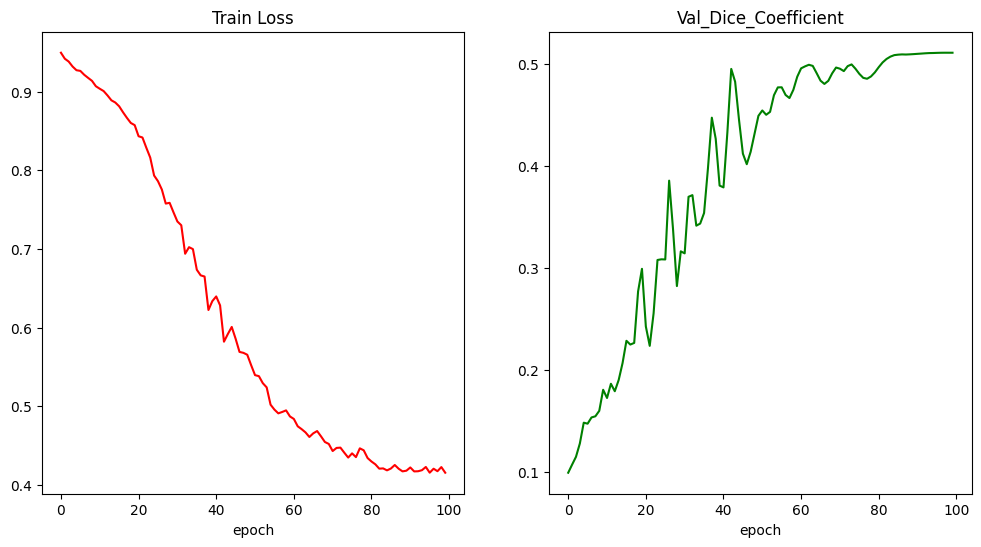

In [ ]:
# plot val loss and dice coefficient
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train Loss")
plt.xlabel("epoch")
plt.plot(trains_epoch, loss_epochs, color="red")
plt.subplot(1, 2, 2)
plt.title("Val_Dice_Coefficient")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_avg, color="green")
plt.savefig("loss_and_val_dice.png")

In [ ]:
np.save("losses.npy", loss_epochs)
np.save("dice.npy", dices_avg)

## Make Predictions
We creating a transforms `Compose` object to prepare our single image-label pair to be passed to the model for evaluation.

In [ ]:
test_files = [
    {
      "image": "/content/drive/MyDrive/stroke/data/split/val/images/image_367.npy",
      "label": "/content/drive/MyDrive/stroke/data/split/val/masks/mask_367.npy"
    },
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.AsChannelFirstd(keys=["image", "label"]),
        transforms.Resized(
            keys=["image", "label"],
            spatial_size=roi,
            size_mode="all"
        ),
        transforms.ToTensord(keys=["image", "label"]),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
<class 'monai.transforms.utility.dictionary.AsChannelFirstd'>: Class `AsChannelFirstd` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead.
This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


#Load best model
We load the `state_dict` of the best saved model, and use it to make predictions. We then threshold the mask, and plot the image, along with the ground truth and prediction

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
None of the inputs have requires_grad=True. Gradients will be None


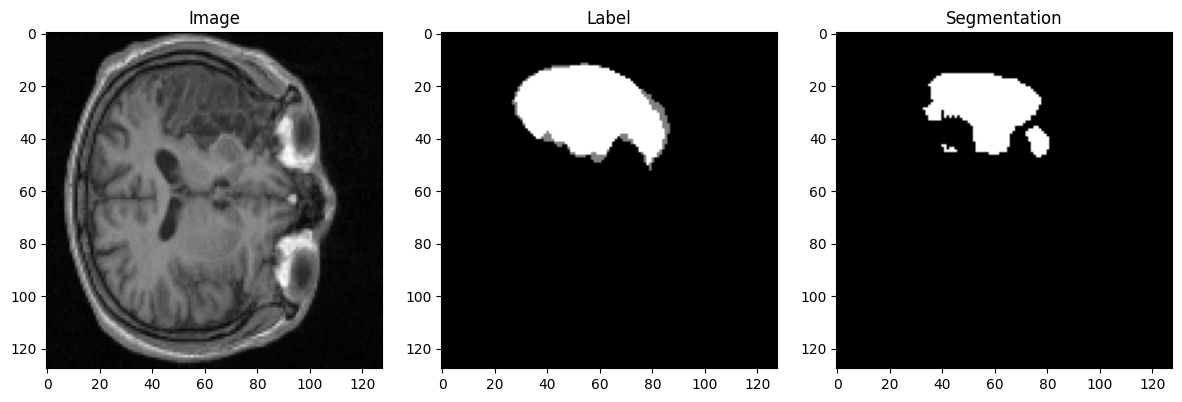

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/stroke/data/unetr-model.pt")["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].cuda()
        label = batch_data["label"].cpu().numpy()

        # Ensure that the image and the segmentation have the same spatial dimensions
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.uint8)

        # Plot the image, label, and segmentation as subplots
        image = image.cpu().numpy()
        img = np.transpose(image[0], (1, 2, 3, 0))
        lbl = np.transpose(label[0], (1, 2, 3, 0))
        seg = np.transpose(seg, (1, 2, 3, 0))

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img[:, :, 40], cmap="gray")
        plt.title("Image")

        plt.subplot(1, 3, 2)
        plt.imshow(lbl[:, :, 40], cmap="gray")
        plt.title("Label")

        plt.subplot(1, 3, 3)
        plt.imshow(seg[:, :, 40], cmap="gray")
        plt.title("Segmentation")

        plt.tight_layout()
        plt.savefig("Monai_pred.png")

#END